In [1]:
# Analysis on cooling effects from water bodies in Copenhagen 

# changes in Land Surface Temperature (LST) is used to detect the cooling effects

#lst_case.tif: The study area extent is created through a Union and a 
#Dissolve of the lakes_and_sea dataset and the official extents of 
#the two municipalities; the City of Copenhagen and Frederiksberg. 
#The calculated LST result is converted to EPSG:25832 with Project Raster 
#and cut to the case study extent with Extract by Mask and used as template 
#for further raster processing (Environment settings for extent, cell size, 
#mask, and snap raster). 

#lakes.shp and seas.shp: The lakes (or seas respectively) are selected in 
#the lakes_and_sea dataset (Select By Attributes) and extracted to their 
#own layer (Copy Features).  

#lakes_case.tif and seas_case.tif: The lakes (or seas respectively) are 
#converted into a raster (Raster to Polygon) with the same parameters as 
#the LST for the case study area.  

#euc_lake_distV2.tif and euc_seas_distV2.tif: Euclidean Distance is used 
#to calculate the distance to the nearest lake (or sea respectively) for 
#each raster cell following the parameters as the LST for the case study area.  

#lakes_source_near.tif and seas_source_near.tif: Euclidean Allocation is 
#used to provide the id in each raster cell of the nearest lake (or nearest 
#sea polygon respectively) following the parameters as the LST for the 
#case study area.


In [133]:
#pip install statsmodels
#pip install pandas matplotlib
#pip install numpy
#pip install scipy
#pip install geopandas
#!pip install matplotlib-scalebar
#pip...

In [160]:
# SETUP
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
import contextily as cx # for getting background maps
from shapely.geometry import box # for getting bbox
import statsmodels.api as sm  # Import statsmodels for regression
from scipy import stats  # For regression analysis
from scipy.stats import mannwhitneyu
from sklearn.metrics import r2_score


In [161]:
# SETUP
# import rasters
lst = rasterio.open('landsat20190606/lst_20190606_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
lakes_source_near = rasterio.open('analysis_input_data/lakes_source_near.tif').read(1).astype('float64') # id of nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea
seas_source_near = rasterio.open('analysis_input_data/seas_source_near.tif').read(1).astype('float64') # id of nearest sea polygon
dict_for_counting_TP = {}
dict_for_counting_n_pos = {}
dict_for_counting_n_neg = {}


In [162]:
# SETUP
# Read the shapefile
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
#lakes = gpd.read_file("lakes.shp") # all lake polygons with attribute data
print(lakes.head()) # Show the first few rows of the dataframe

# Read the shapefile
seas = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
print(seas.head()) # Show the first few rows of the dataframe

   fid_    id objekt_typ        kommune    area_ha  perimeter       details  \
0     0  1138         Sø  Frederiksberg   0.096052         73   obs cooling   
1     0   240         Sø      København  14.834820       2288  close to sea   
2     0  1140         Sø      København   3.693557        918   obs cooling   
3     0   517         Sø      København   6.313699        625   obs cooling   
4     0   516         Sø      København   0.804220        389   obs cooling   

   obs_dist    obs_lst    est_dist    est_lst   cool_trend  herbCross  \
0       315  27.794376  171.010603  25.908302     positive        NaN   
1       165  28.605614  242.849081  28.548786  seaPositive        NaN   
2       255  28.224209  223.030366  26.633807     positive        NaN   
3        75  24.103312  230.672440  26.776500     positive        NaN   
4       135  26.649478  201.300379  27.251340     positive        NaN   

   herbCoolCr  woodCoolCr  vegOverlap            vegExplain  \
0         NaN         N

In [163]:
# Read the shapefile
ua_herb = gpd.read_file("analysis_input_data/ua_herb.shp") # all sea polygons with attribute data
print(ua_herb.head()) # Show the first few rows of the dataframe

ua_forest = gpd.read_file("analysis_input_data/ua_forests.gpkg") # all sea polygons with attribute data
print(ua_herb.head()) # Show the first few rows of the dataframe

  country   fua_name fua_code code_2018  \
0      DK  København  DK001L2     32000   
1      DK  København  DK001L2     32000   
2      DK  København  DK001L2     32000   
3      DK  København  DK001L2     32000   
4      DK  København  DK001L2     32000   

                                          class_2018 prod_date     identifier  \
0  Herbaceous vegetation associations (natural gr...   2020-06  40014-DK001L2   
1  Herbaceous vegetation associations (natural gr...   2020-06  39640-DK001L2   
2  Herbaceous vegetation associations (natural gr...   2020-06  39645-DK001L2   
3  Herbaceous vegetation associations (natural gr...   2020-06  39652-DK001L2   
4  Herbaceous vegetation associations (natural gr...   2020-06  39653-DK001L2   

      perimeter          area comment  Pop2018  \
0  11566.013838  1.226920e+06    None        0   
1    486.927159  1.276423e+04    None        0   
2    806.366373  2.620140e+04    None        0   
3   2957.346035  6.049599e+04    None        0   
4   

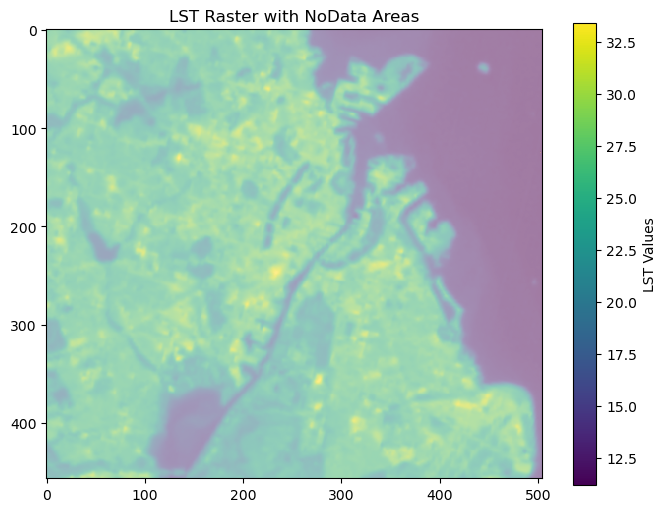

In [164]:
# SETUP
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

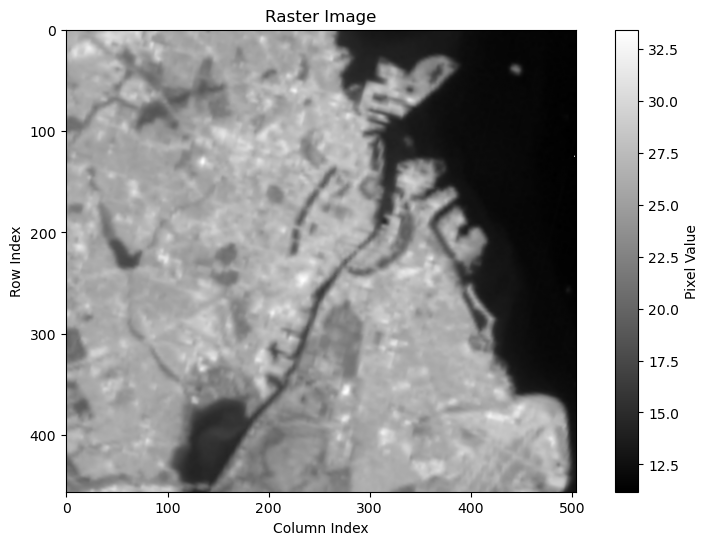

In [165]:
# SETUP
# Plot the LST raster data
plt.figure(figsize=(10, 6))
plt.imshow(lst, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [166]:
# SETUP
# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData

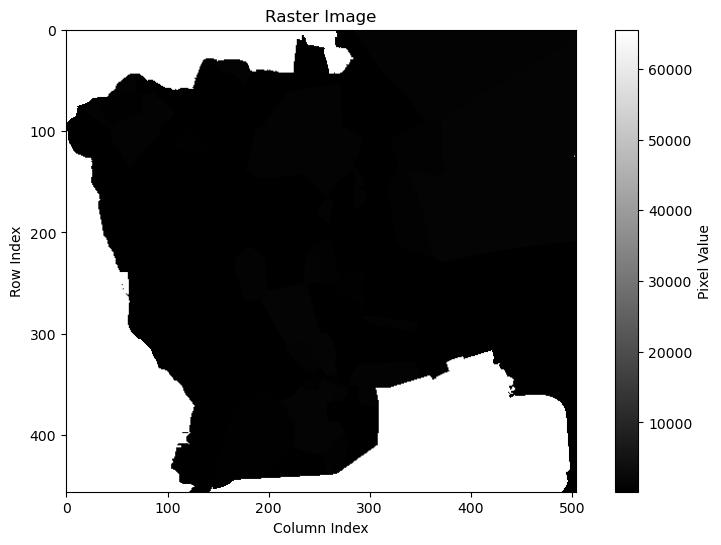

In [167]:
# SETUP
# Plot example raster
plt.figure(figsize=(10, 6))
plt.imshow(lakes_source_near, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

LST at Sea (0m): 23.246493201336996
Turning Point Distance (last increasing point before decrease): 225 meters
LST at First Bin (30-60m): 23.98312866818929
LST at Turning Point: 26.61083983272615
LST Increase Between First Bin (30-60m) and Turning Point: 2.6277111645368576
P-value for logarithmic fit: 0.0001
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


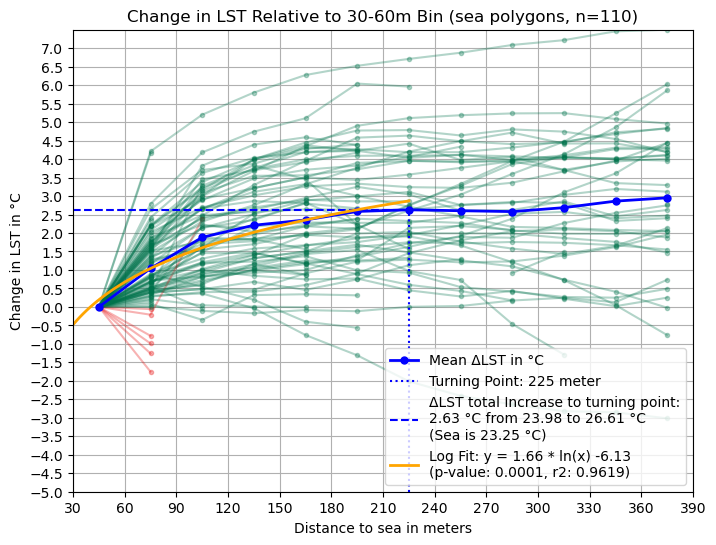

In [168]:
### Analysis 1: Cooling effect from distance to sea - ALL SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30) #720  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

ids_of_seas_negative_trend = []
ids_of_seas_positive_trend = []

# Iterate through each unique sea ID
for sea_id in subset_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1) #700
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #digitize assigns each distance value to a bin number
    #values 30-60 has been assigned an index of 1 but this is changed to index 0 after subtracting 1
    #this is because dist values are not to be considered for 30-60m (now bin index=0)
    #bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute a list of mean LST in each distance bin i for bins >= 60-90m 
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]

    # append this sea's lst change as a list to a larger list (list within list) 
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index 0
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index 1
        #index_105_sea = np.where(bin_labels_sea == 105)[0][0]  # Extract scalar index 2
        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red
            if line_color_sea == '#00734C': #00734C=green
                ids_of_seas_positive_trend.append(sea_id)
            elif line_color_sea == '#E60000': #E60000=red
                ids_of_seas_negative_trend.append(sea_id)
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# FINDING AVERAGE TURNING POINT ACROSS ALL SEAS: 
# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0) #find the index of the first negative slope  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

info_data_type= "sea"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst_sea,
        "distance": turning_point_distance_sea
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_seas_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_seas_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -5
y_end = 7.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a_sea:.2f} * ln(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (sea polygons, n={len(subset_seas)})")
plt.xticks(bins_sea) 
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='lower right')
plt.savefig("Fig20190606_sea_all.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Sea (0m): 14.544346529182825
Turning Point Distance (last increasing point before decrease): 195 meters
LST at First Bin (30-60m): 20.913832905197314
LST at Turning Point: 24.97490592144833
LST Increase Between First Bin (30-60m) and Turning Point: 4.061073016251015
P-value for logarithmic fit: 0.0009
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


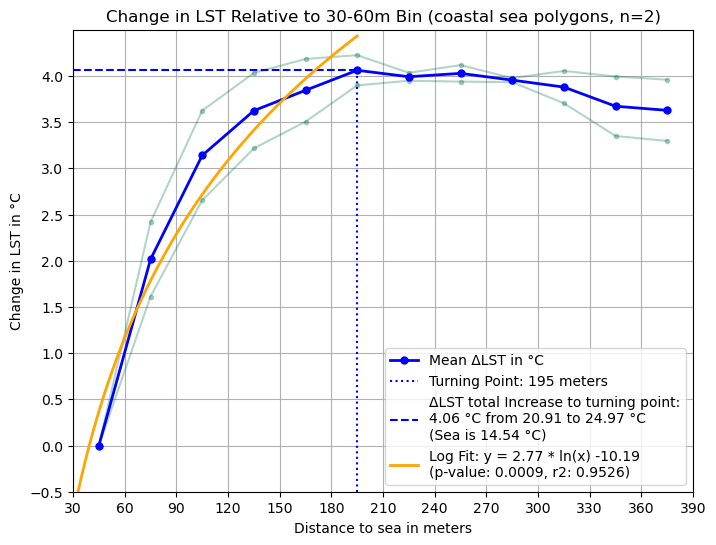

In [143]:
### Analysis 2: Cooling effect from distance to sea - ONLY LARGER SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30)  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]
# Subset unique_ids_seas_all to only include elements in larger_seas
larger_seas = (1348, 1163)  
subset_larger_seas = subset_seas[np.isin(subset_seas, larger_seas)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

ids_of_seas_negative_trend = []
ids_of_seas_positive_trend = []

# Iterate through each unique sea ID
for sea_id in subset_larger_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1)
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    #print("we show ", lst[lst_at_0_mask_sea])
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute mean LST for each distance bin
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]
    
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red
            if line_color_sea == '#00734C': #00734C=green
                ids_of_seas_positive_trend.append(sea_id)
            elif line_color_sea == '#E60000': #E60000=red
                ids_of_seas_negative_trend.append(sea_id)
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0)  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

info_data_type= "sea_coastal"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst_sea,
        "distance": turning_point_distance_sea
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_seas_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_seas_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -0.5
y_end = 4.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, label=f"Log Fit: y = {a_sea:.2f} * ln(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (coastal sea polygons, n={len(subset_larger_seas)})")
plt.xticks(bins_sea)

yticks = np.arange(-0.5, 4.5, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)

plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_sea_coastal.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Sea (0m): 23.40764406563615
Turning Point Distance (last increasing point before decrease): 225 meters
LST at First Bin (30-60m): 24.04049868245082
LST at Turning Point: 26.60479630197309
LST Increase Between First Bin (30-60m) and Turning Point: 2.564297619522266
P-value for logarithmic fit: 0.0001
The logarithmic fit is statistically significant.
Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.
This means that there is statistically significant evidence that the sea distance (log-transformed)
has an effect on the change in LST.


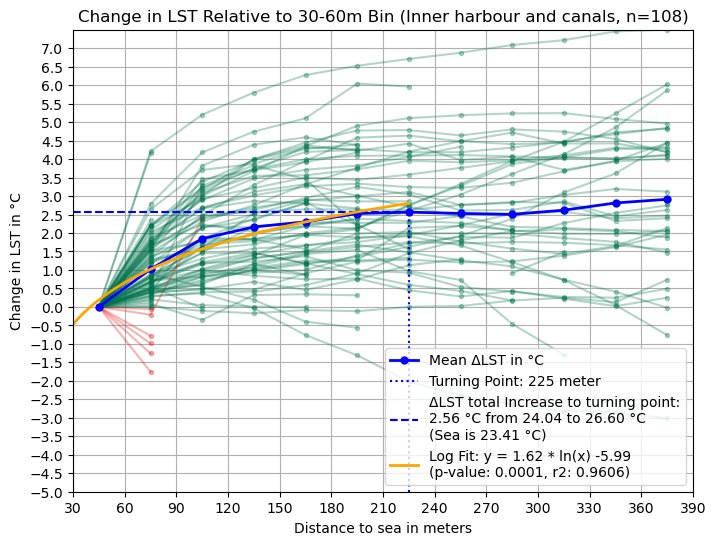

In [144]:
### Analysis 3: Cooling effect from distance to sea - ONLY INNER SEAS 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins_sea = np.arange(30, 420, 30)  
bin_labels_sea = bins_sea[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique sea IDs, ignoring NaNs
unique_ids_seas_all = np.unique(seas_source_near[~np.isnan(seas_source_near)])
# Exclude small sea area round small island (Middelgrundsfortet) which is an outlier
subset_seas = unique_ids_seas_all[~np.isin(unique_ids_seas_all, 165)]
# Subset unique_ids_seas_all to only include elements in larger_seas
larger_seas = (1348, 1163)
subset_not_larger_seas = subset_seas[~np.isin(subset_seas, larger_seas)]

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all seas
all_delta_lst_sea = []

# Storage for zero dist LST across all seas
all_lst_at_0_sea = []

# Storage for 30-60 dist LST across all seas
all_lst_at_30_60_sea = []

ids_of_seas_negative_trend = []
ids_of_seas_positive_trend = []

# Iterate through each unique sea ID
for sea_id in subset_not_larger_seas:
    base_mask_sea = (seas_source_near == sea_id) & (sea_dist < 400) & ~np.isnan(sea_dist) & ~np.isnan(lst) & (lakes_case != 1)
    
    if np.sum(base_mask_sea) == 0:
        continue

    # Compute mean LST for `dist = 0` (used as reference)
    lst_at_0_mask_sea = base_mask_sea & (sea_dist == 0)
    lst_at_0_sea = np.mean(lst[lst_at_0_mask_sea]) if np.any(lst_at_0_mask_sea) else np.nan

    all_lst_at_0_sea.append(lst_at_0_sea)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask_sea = base_mask_sea & (sea_dist >= 30) & (sea_dist < 60)
    lst_at_30_60_sea = np.mean(lst[lst_at_30_60_mask_sea]) if np.any(lst_at_30_60_mask_sea) else np.nan
    
    all_lst_at_30_60_sea.append(lst_at_30_60_sea)

    mask_sea = base_mask_sea & ~((sea_dist >= 30) & (sea_dist < 60))
    
    if np.sum(mask_sea) == 0:
        continue

    raster1_vals_sea = sea_dist[mask_sea]
    raster2_vals_sea = lst[mask_sea]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices_sea = np.digitize(raster1_vals_sea, bins_sea, right=False) - 1  # Ensure correct binning

    # Compute mean LST for each distance bin
    mean_lst_values_sea = [np.mean(raster2_vals_sea[bin_indices_sea == i]) if np.any(bin_indices_sea == i) else np.nan for i in range(len(bin_labels_sea))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst_sea = [0 if bin_labels_sea[i] == 45 else (mean_lst_values_sea[i] - lst_at_30_60_sea if not np.isnan(mean_lst_values_sea[i]) else np.nan) for i in range(len(bin_labels_sea))]
    
    all_delta_lst_sea.append(delta_lst_sea)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45_sea = np.where(bin_labels_sea == 45)[0][0]  # Extract scalar index
        index_75_sea = np.where(bin_labels_sea == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst_sea[index_45_sea]) and not np.isnan(delta_lst_sea[index_75_sea]):
            line_color_sea = '#00734C' if delta_lst_sea[index_75_sea] > delta_lst_sea[index_45_sea] else '#E60000' #00734C=green #E60000=red
            if line_color_sea == '#00734C': #00734C=green
                ids_of_seas_positive_trend.append(sea_id)
            elif line_color_sea == '#E60000': #E60000=red
                ids_of_seas_negative_trend.append(sea_id)
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual sea ΔLST curves in the background
    plt.plot(bin_labels_sea, delta_lst_sea, color=line_color_sea, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all seas for each distance band starting from bin 30-60
mean_delta_lst_sea = np.nanmean(np.array(all_delta_lst_sea), axis=0)

# Compute mean LST across all seas at dist=0
mean_lst_at_0_sea = np.nanmean(np.array(all_lst_at_0_sea), axis=0)

# Compute mean LST across all seas at dist=30-60
mean_lst_at_30_60_sea = np.nanmean(np.array(all_lst_at_30_60_sea), axis=0)

# Compute the slope between successive bins
slopes_sea = np.diff(mean_delta_lst_sea) / np.diff(bin_labels_sea)

# Find the last increasing point before a decrease (turning point)
turning_point_index_sea = np.argmax(slopes_sea < 0)  

if turning_point_index_sea > 0:
    turning_point_distance_sea = bin_labels_sea[turning_point_index_sea]  
else:
    turning_point_distance_sea = np.nan  # No clear turning point found

# Get relative LST at the turning point distance
turning_point_lst_sea = mean_delta_lst_sea[turning_point_index_sea] if not np.isnan(turning_point_distance_sea) else np.nan

info_data_type= "sea_inner_harbour"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst_sea,
        "distance": turning_point_distance_sea
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_seas_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_seas_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Sea (0m): {mean_lst_at_0_sea}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance_sea} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60_sea}")
print(f"LST at Turning Point: {mean_lst_at_30_60_sea+turning_point_lst_sea}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst_sea}")

# start the plotting 
plt.xlim(bins_sea[1], bins_sea[-1])
y_start = -5
y_end = 7.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all seas
plt.plot(bin_labels_sea, mean_delta_lst_sea, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance_sea, ymin=y_start, 
            ymax=turning_point_lst_sea, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance_sea} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_sea, 30, turning_point_distance_sea, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst_sea:.2f} °C from {(mean_lst_at_30_60_sea):.2f} to {(mean_lst_at_30_60_sea+turning_point_lst_sea):.2f} °C\n(Sea is {mean_lst_at_0_sea:.2f} °C)")

# Perform logarithmic fitting only for points between the first bin (30-60m) and the turning point
if not np.isnan(turning_point_distance_sea):
    valid_indices_sea = (np.array(bin_labels_sea) >= 30) & (np.array(bin_labels_sea) <= turning_point_distance_sea)
    x_fit_sea = np.array(bin_labels_sea)[valid_indices_sea]
    y_fit_sea = np.array(mean_delta_lst_sea)[valid_indices_sea]

    # Remove NaN values before fitting
    valid_mask_sea = ~np.isnan(y_fit_sea)
    x_fit_sea = x_fit_sea[valid_mask_sea]
    y_fit_sea = y_fit_sea[valid_mask_sea]

    if len(x_fit_sea) > 1:  # Ensure enough points for fitting
        # Log transform x values for logarithmic fit
        x_log_sea = np.log(x_fit_sea)
        # Add a constant to the x values (for statsmodels OLS)
        x_log_with_const_sea = sm.add_constant(x_log_sea)
        # Fit the model using statsmodels
        model_sea = sm.OLS(y_fit_sea, x_log_with_const_sea)
        results_sea = model_sea.fit()

        # Extract parameters and p-value
        a_sea = results_sea.params[1]  # Coefficient for log(x)
        b_sea = results_sea.params[0]  # Intercept
        p_value_sea = results_sea.pvalues[1]  # p-value for the logarithmic coefficient
        r2_value_sea = results_sea.rsquared
   
        # Plot the logarithmic fit curve
        x_fit_line_sea = np.linspace(30, turning_point_distance_sea, 100)
        y_fit_line_sea = a_sea * np.log(x_fit_line_sea) + b_sea
        plt.plot(x_fit_line_sea, y_fit_line_sea, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a_sea:.2f} * ln(x) {b_sea:.2f}\n(p-value: {p_value_sea:.4f}, r2: {r2_value_sea:.4f})")
        
        # Print the p-value
        print(f"P-value for logarithmic fit: {p_value_sea:.4f}")
        if p_value_sea < 0.05:
            print("The logarithmic fit is statistically significant.")
        print("Since the p-value is smaller than 0.05, you reject the null hypothesis at the 5% significance level.\nThis means that there is statistically significant evidence that the sea distance (log-transformed)\nhas an effect on the change in LST.")

# Final plot adjustments
plt.xlabel("Distance to sea in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Inner harbour and canals, n={len(subset_not_larger_seas)})")
plt.xticks(bins_sea)  
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='lower right')
plt.savefig("Fig20190606_sea_inner.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 23.730347818732948
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 24.081257114478213
LST at Turning Point: 25.62230817974342
LST Increase Between First Bin (30-60m) and Turning Point: 1.5410510652652085
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


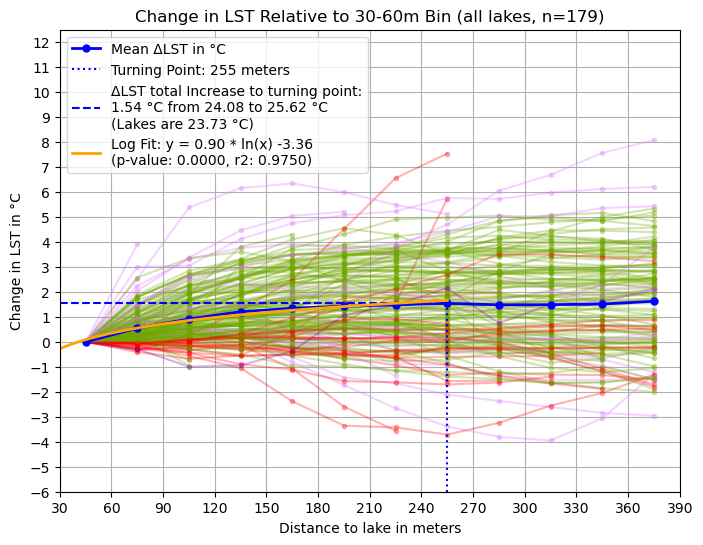

In [145]:
### Analysis 4: Cooling effect from distance to all lakes 
# with lakes within 195 metres to the seas colored differently
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30) #720
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Get all unique lake IDs, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Storage for lake IDs
ids_of_lakes_close_to_sea = []
ids_of_lakes_not_close_to_sea = []
ids_of_lakes_others = []
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []
lst_by_bin = {}

# Iterate through each unique lake ID
for lake_id in unique_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) #700
    
    if np.sum(base_mask) == 0:
        ids_of_lakes_others.append(lake_id)
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index
        #index_105 = np.where(bin_labels == 105)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                ids_of_lakes_close_to_sea.append(lake_id)
                #if delta_lst[index_75] == delta_lst[index_45]:
                    #if delta_lst[index_105] > delta_lst[index_75]:
                        #line_color = '#DF73FF'
                    #else: 
                        #line_color = '#8400A8'
                #if delta_lst[index_75] > delta_lst[index_45]:
                    #line_color = '#DF73FF'
                #else: 
                    #line_color = '#8400A8'
                if line_color == '#DF73FF': #delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                ids_of_lakes_not_close_to_sea.append(lake_id)
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)

        else:
            ids_of_lakes_others.append(lake_id)
            continue  # Skip plotting if NaN values exist
    except IndexError:
        ids_of_lakes_others.append(lake_id)
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# 0–30 m (use midpoint 15)
lst_by_bin[15] = mean_lst_at_0
# 30–60 m (use midpoint 45)
lst_by_bin[45] = mean_lst_at_30_60
# bins beyond 60 m, but only up to turning point
for i, midpoint in enumerate(bin_labels):
    if midpoint <= 45:
        continue
    if midpoint > turning_point_distance:
        break

    delta_val = mean_delta_lst[i]

    lst_by_bin[midpoint] = (
        mean_lst_at_30_60 + delta_val
        if not np.isnan(delta_val)
        else np.nan
    )

info_data_type= "lakes"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst,
        "distance": turning_point_distance
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_lakes_seaclose_positive_trend)+len(ids_of_lakes_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_lakes_seaclose_negative_trend)+len(ids_of_lakes_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 12.5
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * ln(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")
 
        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (all lakes, n={179})") #len(unique_ids) is 182 but these include 3=justOutOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_all.png", dpi=400, bbox_inches="tight")
plt.show()


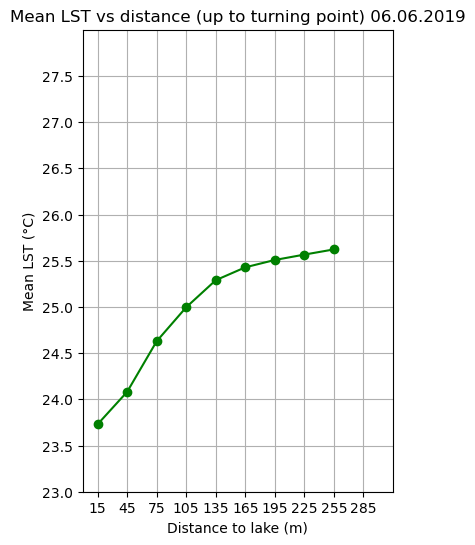

In [146]:
# PLOT MEAN LST FOR EACH DISTANCE BAND TO ALL LAKES 
x = sorted(lst_by_bin.keys())
y = [lst_by_bin[k] for k in x]

plt.figure(figsize=(4, 6))
plt.plot(x, y, marker='o', color="green")
plt.xlabel("Distance to lake (m)")
plt.ylabel("Mean LST (°C)")
plt.title("Mean LST vs distance (up to turning point) 06.06.2019")
y_start = 23
y_end = 28
plt.ylim(y_start, y_end)
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
x_start = 0
x_end = 315
plt.xlim(x_start, x_end)
xticks = np.arange(15, x_end, 30)  # Adjust range and step as needed
plt.xticks(xticks)
plt.grid(True)
plt.savefig("Fig20190606_meanLSTperBin.png", dpi=400, bbox_inches="tight")
plt.show()

LST at Lakes (0m): 21.898181269887036
Turning Point Distance (last increasing point before decrease): 105 meters
LST at First Bin (30-60m): 22.49290868774698
LST at Turning Point: 23.630341801488782
LST Increase Between First Bin (30-60m) and Turning Point: 1.1374331137418021
P-value for logarithmic fit: 0.1606


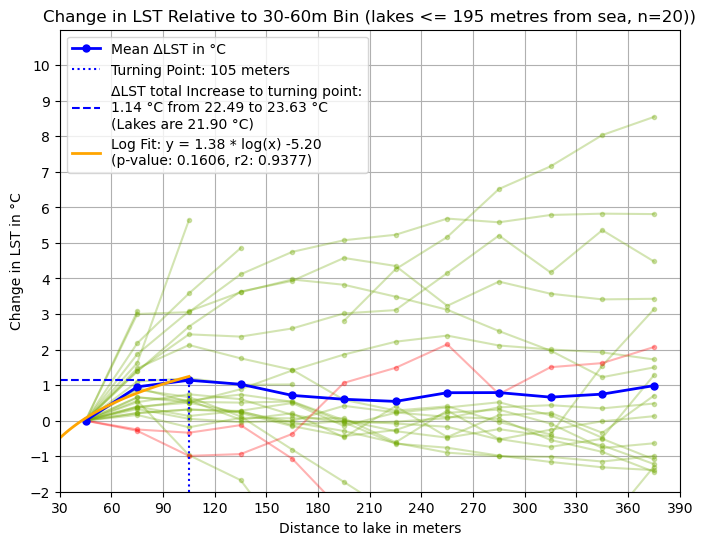

In [147]:
### ANALYSIS 5: Cooling effect from distance to LAKES CLOSE TO SEA 
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist <= 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (lakes <= 195 metres from sea, n=20))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_closeToSea.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 23.833076350526298
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 24.202756486124848
LST at Turning Point: 25.766085715694263
LST Increase Between First Bin (30-60m) and Turning Point: 1.563329229569415
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


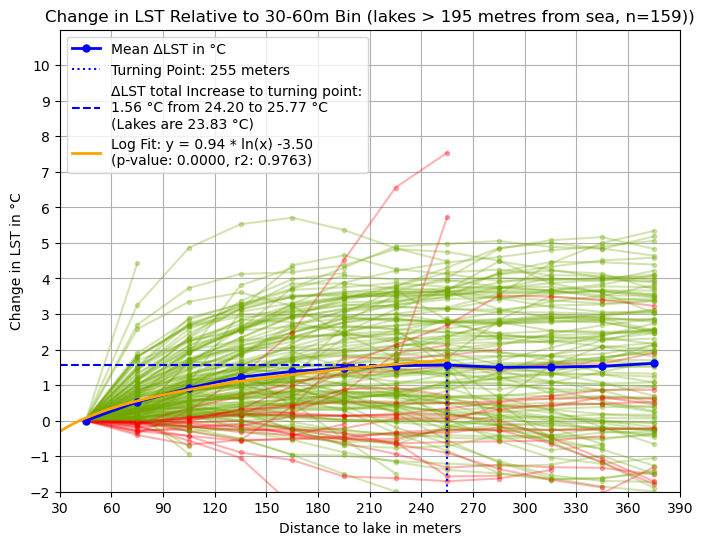

In [148]:
### ANALYSIS 6: Cooling effect from distance to lakes further from sea  
# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0] # 4.68

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * ln(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (lakes > 195 metres from sea, n=159))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_farFromSea.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 20.96451841994119
Turning Point Distance (last increasing point before decrease): 285 meters
LST at First Bin (30-60m): 22.316585187162836
LST at Turning Point: 25.14937335562128
LST Increase Between First Bin (30-60m) and Turning Point: 2.832788168458443
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


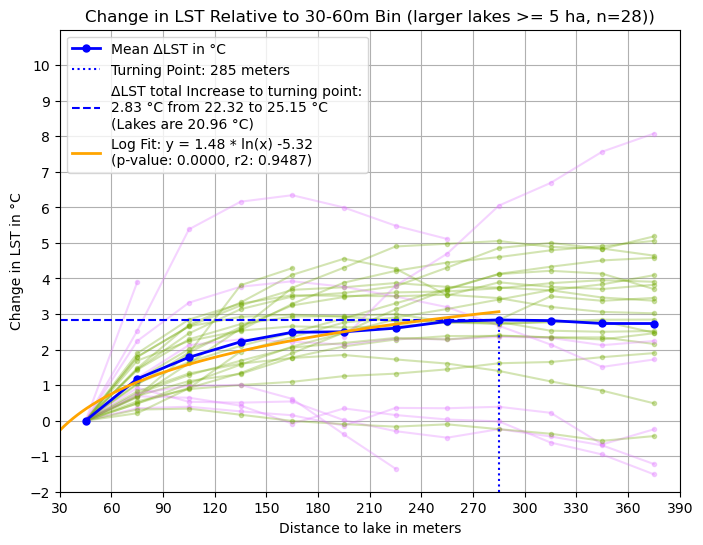

In [149]:
### ANALYSIS 7: Cooling effect from distance to larger lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size >= 5. ha (threshold value for showing cooling effect) 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area greater than or equal to 5 ha
lakes_filtered = lakes[lakes['area_ha'] >= 4.68] #4.68

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# list for colors
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan
    
    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                if line_color == '#DF73FF': #delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)          
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)                
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

info_data_type= "lakes_larger"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst,
        "distance": turning_point_distance
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_lakes_seaclose_positive_trend)+len(ids_of_lakes_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_lakes_seaclose_negative_trend)+len(ids_of_lakes_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * ln(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (larger lakes >= 5 ha, n=28))") #29 but 1 out of scope so 28 {len(np.sort(lakes_filtered['id'])
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_high_area.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 24.23596322795448
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 24.41044143078826
LST at Turning Point: 25.687763214081208
LST Increase Between First Bin (30-60m) and Turning Point: 1.2773217832929469
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


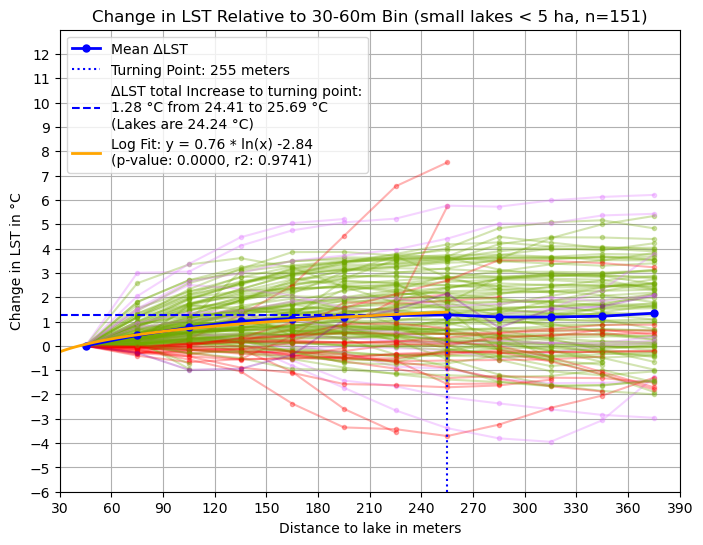

In [150]:
### ANALYSIS 8: Cooling effect from distance to smaller lakes 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size < 5. ha (threshold value for showing cooling effect is 5 ha) 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 420, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lakes with area smaller than 5 ha
lakes_filtered = lakes[lakes['area_ha'] < 5.]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# list for colors
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
        
    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                if line_color == '#DF73FF': #delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)          
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)                
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get LST at the turning point which equals LST increase 
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

info_data_type= "lakes_small"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst,
        "distance": turning_point_distance
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_lakes_seaclose_positive_trend)+len(ids_of_lakes_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_lakes_seaclose_negative_trend)+len(ids_of_lakes_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 13
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meters")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * ln(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (small lakes < 5 ha, n=151)") #{len(unique_ids)-29} 3 outOfScope has been left out
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_low_area.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 21.698931179521754
Turning Point Distance (last increasing point before decrease): 315 meters
LST at First Bin (30-60m): 22.717340752287356
LST at Turning Point: 25.341614110944814
LST Increase Between First Bin (30-60m) and Turning Point: 2.6242733586574585
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


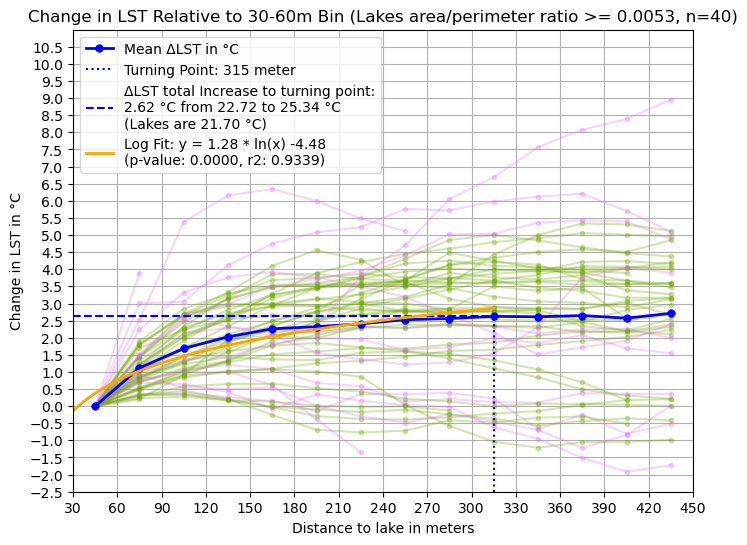

In [151]:
### ANALYSIS 9: Large area divided by perimeter 
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size/perimeter ratio >= 0.0053 (threshold value for showing cooling effect is 0.0053) 

# Define distance bins (30-60, 60-90, ..., 390-480)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Calculate the area/perimeter ratio
lakes['area_perimeter_ratio'] = lakes['area_ha'] / lakes['perimeter']

# Filter lakes with large area/perimeter ratio
lakes_filtered = lakes[lakes['area_perimeter_ratio'] >= 0.0043] #0.0053

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# list for colors
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 480) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]
    
    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:         
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                if line_color == '#DF73FF': #delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)          
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)                
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

info_data_type= "lakes_areaDivPeri"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst,
        "distance": turning_point_distance
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": len(ids_of_lakes_seaclose_positive_trend)+len(ids_of_lakes_positive_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": len(ids_of_lakes_seaclose_negative_trend)+len(ids_of_lakes_negative_trend)
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -2.5
y_end = 11
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Lakes are {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * ln(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes area/perimeter ratio >= 0.0053, n=40)") #{len(np.sort(lakes_filtered['id']))} 46 but 6 are out of scope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 0.5)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_high_perimeter.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes (0m): 24.374561752187464
Turning Point Distance (last increasing point before decrease): 255 meters
LST at First Bin (30-60m): 24.509317936846234
LST at Turning Point: 25.71249398326333
LST Increase Between First Bin (30-60m) and Turning Point: 1.2031760464170944
P-value for logarithmic fit: 0.0000
The logarithmic fit is statistically significant.


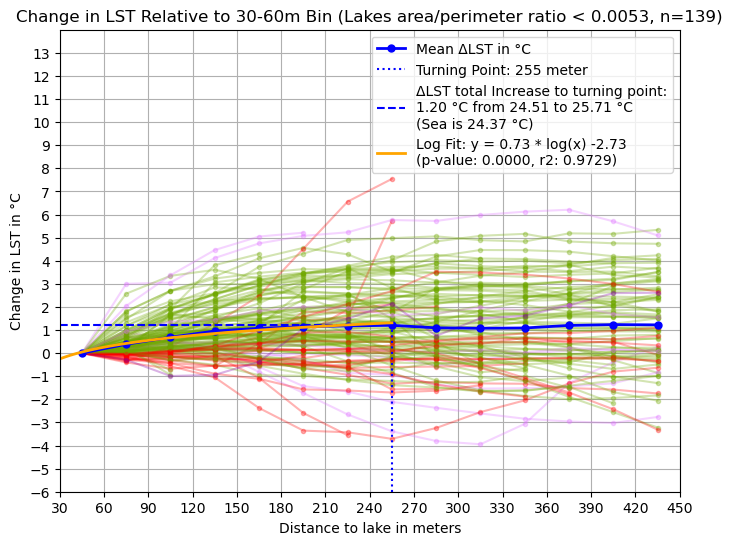

In [152]:
### ANALYSIS 10: Small area divided by perimeter
#with lakes within 195 metres to the seas colored purple
#and only including lakes of size/perimeter ratio < 0.0053 (threshold value for showing cooling effect is 0.0053) 

# Define distance bins (30-60, 60-90, ..., 390-480)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Calculate the area/perimeter ratio
lakes['area_perimeter_ratio'] = lakes['area_ha'] / lakes['perimeter']

# Filter lakes with small area/perimeter ratio
lakes_filtered = lakes[lakes['area_perimeter_ratio'] < 0.0053]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst = []

# Storage for zero LST across all lakes
all_lst_at_0 = []

# Storage for 30-60 dist LST across all lakes
all_lst_at_30_60 = []

# list for colors
ids_of_lakes_negative_trend = []
ids_of_lakes_positive_trend = []
ids_of_lakes_seaclose_positive_trend = []
ids_of_lakes_seaclose_negative_trend = []

# Iterate through each unique lake ID
for lake_id in unique_ids:
    # Check if the current lake ID is in the filtered lakes
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 480) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    all_lst_at_0.append(lst_at_0)

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    all_lst_at_30_60.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]
    
    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    all_delta_lst.append(delta_lst)

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            # Check if the lake is within 195 meters of the sea
            is_near_sea = np.any((lakes_source_near == lake_id) & (lakes_case == 1) & (sea_dist <= 195))
            if is_near_sea:         
                line_color = '#DF73FF' if delta_lst[index_75] > delta_lst[index_45] else '#8400A8' #DF73FF=light purple #8400A8=dark purple
                if line_color == '#DF73FF': #delta_lst[index_75] > delta_lst[index_45]: 
                    ids_of_lakes_seaclose_positive_trend.append(lake_id)
                else: 
                    ids_of_lakes_seaclose_negative_trend.append(lake_id)          
            else:
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' #70A800=green #FF0000=red
                if line_color == '#70A800': #70A800=green
                    ids_of_lakes_positive_trend.append(lake_id)
                elif line_color == '#FF0000': #FF0000=red
                    ids_of_lakes_negative_trend.append(lake_id)                
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes for each distance band starting from bin 30-60
mean_delta_lst = np.nanmean(np.array(all_delta_lst), axis=0)

# Compute mean LST across all lakes at dist=0
mean_lst_at_0 = np.nanmean(np.array(all_lst_at_0), axis=0)

# Compute mean LST across all lakes at dist=30-60
mean_lst_at_30_60 = np.nanmean(np.array(all_lst_at_30_60), axis=0)

# Compute the slope between successive bins
slopes = np.diff(mean_delta_lst) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index = np.argmax(slopes < 0)

if turning_point_index > 0:
    turning_point_distance = bin_labels[turning_point_index]
else:
    turning_point_distance = np.nan

# Get relative LST at the turning point distance
turning_point_lst = mean_delta_lst[turning_point_index] if not np.isnan(turning_point_distance) else np.nan

# Print results
print(f"LST at Lakes (0m): {mean_lst_at_0}")
print(f"Turning Point Distance (last increasing point before decrease): {turning_point_distance} meters")
print(f"LST at First Bin (30-60m): {mean_lst_at_30_60}")
print(f"LST at Turning Point: {mean_lst_at_30_60+turning_point_lst}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point: {turning_point_lst}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 14
plt.ylim(y_start, y_end)

# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label="Mean ΔLST in °C")

# Vertical line at turning point
plt.vlines(turning_point_distance, ymin=y_start, 
            ymax=turning_point_lst, color='blue', linestyle='dotted', label=f"Turning Point: {turning_point_distance} meter")

# Add horizontal line at turning point LST
plt.hlines(turning_point_lst, 30, turning_point_distance, color='blue', linestyle='--', 
           label=f"ΔLST total Increase to turning point:\n{turning_point_lst:.2f} °C from {(mean_lst_at_30_60):.2f} to {(mean_lst_at_30_60+turning_point_lst):.2f} °C\n(Sea is {mean_lst_at_0:.2f} °C)")

# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance):
    valid_indices = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance)
    x_fit = np.array(bin_labels)[valid_indices]
    y_fit = np.array(mean_delta_lst)[valid_indices]

    # Remove NaN values
    valid_mask = ~np.isnan(y_fit)
    x_fit = x_fit[valid_mask]
    y_fit = y_fit[valid_mask]

    if len(x_fit) > 1:
        x_log = np.log(x_fit)
        x_log_with_const = sm.add_constant(x_log)
        model = sm.OLS(y_fit, x_log_with_const)
        results = model.fit()

        a = results.params[1]
        b = results.params[0]
        p_value = results.pvalues[1]
        r2_value = results.rsquared

        # Logarithmic fit curve
        x_fit_line = np.linspace(30, turning_point_distance, 100)
        y_fit_line = a * np.log(x_fit_line) + b
        plt.plot(x_fit_line, y_fit_line, color='orange', linestyle='-', linewidth=2, 
                 label=f"Log Fit: y = {a:.2f} * log(x) {b:.2f}\n(p-value: {p_value:.4f}, r2: {r2_value:.4f})")

        print(f"P-value for logarithmic fit: {p_value:.4f}")
        if p_value < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes area/perimeter ratio < 0.0053, n=139)") #132 with cooling far from sea and with low area/perimeter #7 with cooling close to sea and with low area/perimeter #len(np.sort(lakes_filtered['id'])) includes out of scope too
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.legend()
plt.savefig("Fig20190606_lakes_low_perimeter.png", dpi=400, bbox_inches="tight")
plt.show()


LST at Lakes Herb (0m): 23.612198260572903
LST at Lakes not Herb (0m): 24.014616425719954
Turning Point Distance Herb (last increasing point before decrease): 135 meters
Turning Point Distance not Herb (last increasing point before decrease): 405 meters
LST at First Bin Herb (30-60m): 23.80451592319116
LST at First Bin not Herb (30-60m): 24.396990372934045
LST at Turning Point Herb: 24.432485888724734
LST at Turning Point not Herb: 26.40812469524021
LST Increase Between First Bin (30-60m) and Turning Point Herb: 0.6279699655335741
LST Increase Between First Bin (30-60m) and Turning Point not Herb: 2.0111343223061673
P-value for logarithmic lakes with vegetation fit: 0.0002
The logarithmic fit is statistically significant.
P-value for logarithmic lakes without vegetation fit: 0.0000
The logarithmic fit is statistically significant.


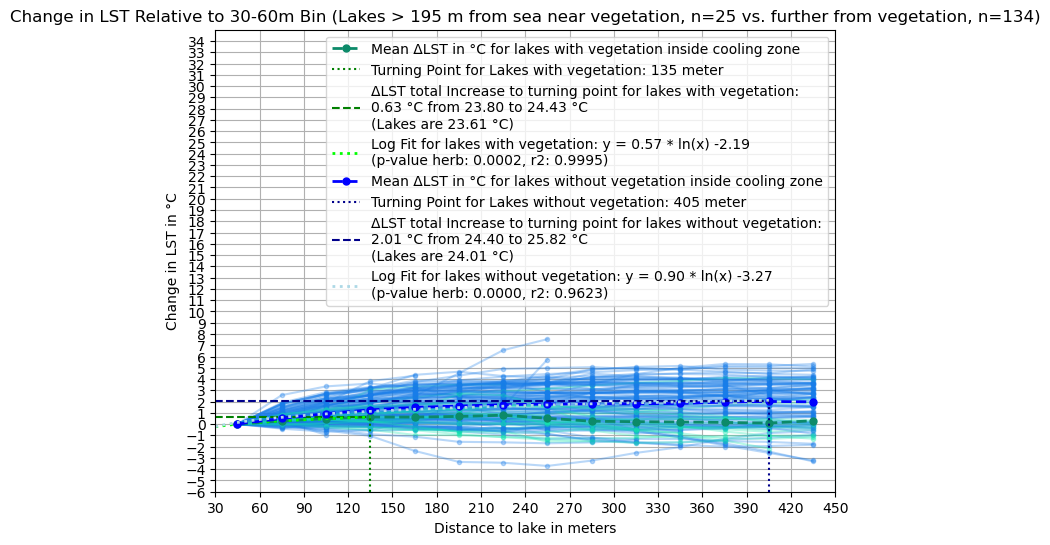

In [153]:
### ANALYSIS 11: VEGETATION
# Cooling effect from lakes close to vegetation (herbs + forest) vs. 
# lakes not close to urban atlas vegetation (herbs+forest) - long distance
#  only calculates for lakes > 195 meters from the sea 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lake ids with herb
lakes_filtered_cool = lakes[lakes['cool_trend'].isin(['positive', 'negative'])] #159
lakes_herb_statistics_ids = np.sort(np.unique(lakes_filtered_cool['id']))

lakes_filtered_herb = lakes_filtered_cool[lakes_filtered_cool['vegOverlap'] >= 1] #25 
lakes_with_herb_ids = np.sort(np.unique(lakes_filtered_herb['id']))

lakes_without_herb_ids = np.setdiff1d(lakes_herb_statistics_ids, lakes_with_herb_ids)
lakes_without_herb = lakes_filtered_cool[lakes_filtered_cool['id'].isin(lakes_without_herb_ids)] #134

plt.figure(figsize=(8, 6))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst_herb = []
all_delta_lst_not_herb = []

# Storage for zero LST across all lakes
all_lst_at_0_herb = []
all_lst_at_0_not_herb = []

# Storage for 30-60 LST across all lakes
all_lst_at_30_60_herb = []
all_lst_at_30_60_not_herb = []

# Iterate through each unique lake ID
for lake_id in lakes_herb_statistics_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 800) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_0_herb.append(lst_at_0)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_0_not_herb.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_30_60_herb.append(lst_at_30_60)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_30_60_not_herb.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    if lake_id in lakes_with_herb_ids:
        all_delta_lst_herb.append(delta_lst)
    elif lake_id in lakes_without_herb_ids:
        all_delta_lst_not_herb.append(delta_lst)
   
    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if lake_id in lakes_with_herb_ids: 
                line_color = '#14E7AE' # lakes with herb is colored green "green"
            else:
                line_color = '#187DE9' # lakes without herb is colored blue='#187DE9'

        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
mean_delta_lst_herb = np.nanmean(np.array(all_delta_lst_herb), axis=0)
mean_delta_lst_not_herb = np.nanmean(np.array(all_delta_lst_not_herb), axis=0)

# Compute LST across all lakes for dist=0
mean_lst_at_0_herb = np.nanmean(np.array(all_lst_at_0_herb), axis=0)
mean_lst_at_0_not_herb = np.nanmean(np.array(all_lst_at_0_not_herb), axis=0)

# Compute LST across all lakes for dist=30-60
mean_lst_at_30_60_herb = np.nanmean(np.array(all_lst_at_30_60_herb), axis=0)
mean_lst_at_30_60_not_herb = np.nanmean(np.array(all_lst_at_30_60_not_herb), axis=0)

# Compute the slope between successive bins
slopes_herb = np.diff(mean_delta_lst_herb) / np.diff(bin_labels)
slopes_not_herb = np.diff(mean_delta_lst_not_herb) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index_herb = np.argmax(slopes_herb < 0)
turning_point_index_not_herb = np.argmax(slopes_not_herb < 0)

if turning_point_index_herb > 0:
    turning_point_distance_herb = bin_labels[turning_point_index_herb]
else:
    turning_point_distance_herb = np.nan
if turning_point_index_not_herb > 0:
    turning_point_distance_not_herb = bin_labels[turning_point_index_not_herb]
else:
    turning_point_distance_not_herb = np.nan

# Get LST at the turning point which equals LST increase 
turning_point_lst_herb = mean_delta_lst_herb[turning_point_index_herb] if not np.isnan(turning_point_distance_herb) else np.nan
turning_point_lst_not_herb = mean_delta_lst_not_herb[turning_point_index_not_herb] if not np.isnan(turning_point_distance_not_herb) else np.nan

# Print results
print(f"LST at Lakes Herb (0m): {mean_lst_at_0_herb}")
print(f"LST at Lakes not Herb (0m): {mean_lst_at_0_not_herb}")
print(f"Turning Point Distance Herb (last increasing point before decrease): {turning_point_distance_herb} meters")
print(f"Turning Point Distance not Herb (last increasing point before decrease): {turning_point_distance_not_herb} meters")
print(f"LST at First Bin Herb (30-60m): {mean_lst_at_30_60_herb}")
print(f"LST at First Bin not Herb (30-60m): {mean_lst_at_30_60_not_herb}")
print(f"LST at Turning Point Herb: {mean_lst_at_30_60_herb+turning_point_lst_herb}")
print(f"LST at Turning Point not Herb: {mean_lst_at_30_60_not_herb+turning_point_lst_not_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point Herb: {turning_point_lst_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point not Herb: {turning_point_lst_not_herb}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 35
plt.ylim(y_start, y_end)

# Plots for lakes containing herb
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_herb, color='#0C8A69', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen
         label="Mean ΔLST in °C for lakes with vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_herb, ymin=y_start, ymax=turning_point_lst_herb, color='green', linestyle='dotted', 
            label=f"Turning Point for Lakes with vegetation: {turning_point_distance_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_herb, 30, turning_point_distance_herb, color='green', linestyle='--', 
           label=f"ΔLST total Increase to turning point for lakes with vegetation:\n{turning_point_lst_herb:.2f} °C from {(mean_lst_at_30_60_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_herb):.2f} °C\n(Lakes are {mean_lst_at_0_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_herb):
    valid_indices_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_herb)
    x_fit_herb = np.array(bin_labels)[valid_indices_herb]
    y_fit_herb = np.array(mean_delta_lst_herb)[valid_indices_herb]

    # Remove NaN values
    valid_mask_herb = ~np.isnan(y_fit_herb)
    x_fit_herb = x_fit_herb[valid_mask_herb]
    y_fit_herb = y_fit_herb[valid_mask_herb]

    if len(x_fit_herb) > 1:
        x_log_herb = np.log(x_fit_herb)
        x_log_with_const_herb = sm.add_constant(x_log_herb)
        model_herb = sm.OLS(y_fit_herb, x_log_with_const_herb)
        results_herb = model_herb.fit()

        a_herb = results_herb.params[1]
        b_herb = results_herb.params[0]
        p_value_herb = results_herb.pvalues[1]
        r2_value_herb = results_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_herb = np.linspace(30, turning_point_distance_herb, 100)
        y_fit_line_herb = a_herb * np.log(x_fit_line_herb) + b_herb
        plt.plot(x_fit_line_herb, y_fit_line_herb, color='lime', linestyle='dotted', linewidth=2, 
                 label=f"Log Fit for lakes with vegetation: y = {a_herb:.2f} * ln(x) {b_herb:.2f}\n(p-value herb: {p_value_herb:.4f}, r2: {r2_value_herb:.4f})")

        print(f"P-value for logarithmic lakes with vegetation fit: {p_value_herb:.4f}")
        if p_value_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Plots for lakes without herb:
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen
         label="Mean ΔLST in °C for lakes without vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_not_herb, ymin=y_start, ymax=turning_point_lst_not_herb, color='darkblue', linestyle='dotted', 
            label=f"Turning Point for Lakes without vegetation: {turning_point_distance_not_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_not_herb, 30, turning_point_distance_not_herb, color='darkblue', linestyle='--', 
           label=f"ΔLST total Increase to turning point for lakes without vegetation:\n{turning_point_lst_not_herb:.2f} °C from {(mean_lst_at_30_60_not_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_not_herb):
    valid_indices_not_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_not_herb)
    x_fit_not_herb = np.array(bin_labels)[valid_indices_not_herb]
    y_fit_not_herb = np.array(mean_delta_lst_not_herb)[valid_indices_not_herb]

    # Remove NaN values
    valid_mask_not_herb = ~np.isnan(y_fit_not_herb)
    x_fit_not_herb = x_fit_not_herb[valid_mask_not_herb]
    y_fit_not_herb = y_fit_not_herb[valid_mask_not_herb]

    if len(x_fit_not_herb) > 1:
        x_log_not_herb = np.log(x_fit_not_herb)
        x_log_with_const_not_herb = sm.add_constant(x_log_not_herb)
        model_not_herb = sm.OLS(y_fit_not_herb, x_log_with_const_not_herb)
        results_not_herb = model_not_herb.fit()

        a_not_herb = results_not_herb.params[1]
        b_not_herb = results_not_herb.params[0]
        p_value_not_herb = results_not_herb.pvalues[1]
        r2_value_not_herb = results_not_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_not_herb = np.linspace(30, turning_point_distance_not_herb, 100)
        y_fit_line_not_herb = a_not_herb * np.log(x_fit_line_not_herb) + b_not_herb
        plt.plot(x_fit_line_not_herb, y_fit_line_not_herb, color='lightblue', linestyle='dotted', linewidth=2, 
                 label=f"Log Fit for lakes without vegetation: y = {a_not_herb:.2f} * ln(x) {b_not_herb:.2f}\n(p-value herb: {p_value_not_herb:.4f}, r2: {r2_value_not_herb:.4f})")

        print(f"P-value for logarithmic lakes without vegetation fit: {p_value_not_herb:.4f}")
        if p_value_not_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Plot the mean ΔLST across all lakes
#plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, 
#         label=f"Mean ΔLST in °C for lakes without vegetation inside cooling zone\nNo turning point for lakes without vegetation:\nstarting from: {(mean_lst_at_30_60_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes > 195 m from sea near vegetation, n={len(lakes_with_herb_ids)} vs. further from vegetation, n={134})") #len(lakes_without_herb_ids)=151 but 3 are outOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='upper right')
plt.savefig("Fig20190606_lakesWithVegetationVSwithout.png", dpi=400, bbox_inches="tight")
plt.show()


In [154]:
# STATISTICS FOR LAKES WITH HERB VS LAKES WITHOUT HERB 
# Convert lists to numpy arrays
lst30_60_herb = np.array(all_lst_at_30_60_herb)
lst30_60_not_herb = np.array(all_lst_at_30_60_not_herb)

# Remove NaN values
lst30_60_herb = lst30_60_herb[~np.isnan(lst30_60_herb)]
lst30_60_not_herb = lst30_60_not_herb[~np.isnan(lst30_60_not_herb)]

u_stat, p_val_nonparam = mannwhitneyu(lst30_60_herb, lst30_60_not_herb, alternative='two-sided')
print("Mann-Whitney U statistic:", u_stat, "p-value:", p_val_nonparam)
#the Mann–Whitney test provides strong evidence that the two groups of lakes
#(with herbs versus without herbs) are statistically different in the metric you measured

#Mann–Whitney U test (U = 367, p ≈ 0.00275):
#This nonparametric test does not assume normality and shows a statistically significant difference between the two groups. 
#The low p-value indicates that the distributions (often interpreted as medians) of the two groups differ significantly.

#In the Mann–Whitney U test, the U statistic is calculated based on the ranks of all the values from both groups combined. 
#Essentially, it represents the number of times an observation in one group precedes an observation in the other group when 
#all observations are ordered from lowest to highest.

#So, when you see U = 367, it means that—after ranking the data—the test found that there were 367 “wins” for one group over the other. 
#While the number itself (367) isn't directly interpretable in isolation, it is used along with the sample sizes to determine the probability 
#(p-value) of obtaining such a result if the two groups were actually similar. In your case, the corresponding p-value (≈ 0.00275) 
#indicates that the observed difference in rankings between the two groups is highly unlikely to have occurred by chance.

Mann-Whitney U statistic: 1221.0 p-value: 0.039813176790157445


LST at Lakes Herb (0m): 23.612198260572903
Turning Point Distance Herb (last increasing point before decrease): 135 meters
LST at First Bin Herb (30-60m): 23.80451592319116
LST at Turning Point Herb: 24.432485888724734
LST Increase Between First Bin (30-60m) and Turning Point Herb: 0.6279699655335741
P-value for logarithmic lakes with vegetation fit: 0.0002
The logarithmic fit is statistically significant.


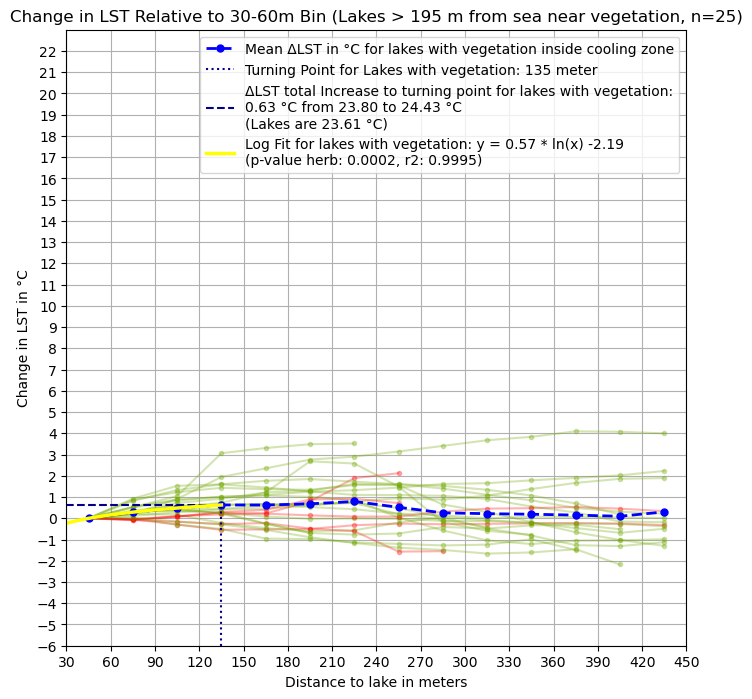

count pos vegetation  20
count neg vegetation  5


In [155]:
### ANALYSIS 12: LAKES WITH VEGETATION
# Cooling effect from lakes close to vegetation (herbs + forest) vs. 
# lakes not close to urban atlas vegetation (herbs+forest) - long distance
#  only calculates for lakes > 195 meters from the sea 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lake ids with herb
lakes_filtered_cool = lakes[lakes['cool_trend'].isin(['positive', 'negative'])] #159
lakes_herb_statistics_ids = np.sort(np.unique(lakes_filtered_cool['id']))

lakes_filtered_herb = lakes_filtered_cool[lakes_filtered_cool['vegOverlap'] >= 1] #25 
lakes_with_herb_ids = np.sort(np.unique(lakes_filtered_herb['id']))

lakes_without_herb_ids = np.setdiff1d(lakes_herb_statistics_ids, lakes_with_herb_ids)
lakes_without_herb = lakes_filtered_cool[lakes_filtered_cool['id'].isin(lakes_without_herb_ids)] #134

plt.figure(figsize=(8, 8))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst_herb = []
all_delta_lst_not_herb = []

# Storage for zero LST across all lakes
all_lst_at_0_herb = []
all_lst_at_0_not_herb = []

# Storage for 30-60 LST across all lakes
all_lst_at_30_60_herb = []
all_lst_at_30_60_not_herb = []

count_pos = 0
count_neg = 0

# Iterate through each unique lake ID
for lake_id in lakes_with_herb_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 800) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_0_herb.append(lst_at_0)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_0_not_herb.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    if lake_id in lakes_with_herb_ids:
        all_lst_at_30_60_herb.append(lst_at_30_60)
    elif lake_id in lakes_without_herb_ids:
        all_lst_at_30_60_not_herb.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    if lake_id in lakes_with_herb_ids:
        all_delta_lst_herb.append(delta_lst)
   
    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if lake_id in lakes_with_herb_ids: 
                #line_color = '#14E7AE' # lakes with herb is colored green "green" #'#14E7AE' '#00ff00' #'#9FC131'
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' 
                if line_color == '#70A800':
                    count_pos += 1 
                elif line_color == '#FF0000':
                    count_neg += 1
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
mean_delta_lst_herb = np.nanmean(np.array(all_delta_lst_herb), axis=0)

# Compute LST across all lakes for dist=0
mean_lst_at_0_herb = np.nanmean(np.array(all_lst_at_0_herb), axis=0)

# Compute LST across all lakes for dist=30-60
mean_lst_at_30_60_herb = np.nanmean(np.array(all_lst_at_30_60_herb), axis=0)

# Compute the slope between successive bins
slopes_herb = np.diff(mean_delta_lst_herb) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index_herb = np.argmax(slopes_herb < 0)

if turning_point_index_herb > 0:
    turning_point_distance_herb = bin_labels[turning_point_index_herb]
else:
    turning_point_distance_herb = np.nan

# Get LST at the turning point which equals LST increase 
turning_point_lst_herb = mean_delta_lst_herb[turning_point_index_herb] if not np.isnan(turning_point_distance_herb) else np.nan

info_data_type= "lakes_withVegetation"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst_herb,
        "distance": turning_point_distance_herb
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": count_pos
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": count_neg
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Print results
print(f"LST at Lakes Herb (0m): {mean_lst_at_0_herb}")

print(f"Turning Point Distance Herb (last increasing point before decrease): {turning_point_distance_herb} meters")
print(f"LST at First Bin Herb (30-60m): {mean_lst_at_30_60_herb}")
print(f"LST at Turning Point Herb: {mean_lst_at_30_60_herb+turning_point_lst_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point Herb: {turning_point_lst_herb}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 23
plt.ylim(y_start, y_end)

# Plots for lakes containing herb
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen '#0C8A69'
         label="Mean ΔLST in °C for lakes with vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_herb, ymin=y_start, ymax=turning_point_lst_herb, color='darkblue', linestyle='dotted', #'green'
            label=f"Turning Point for Lakes with vegetation: {turning_point_distance_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_herb, 30, turning_point_distance_herb, color='darkblue', linestyle='--', #'green'
           label=f"ΔLST total Increase to turning point for lakes with vegetation:\n{turning_point_lst_herb:.2f} °C from {(mean_lst_at_30_60_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_herb):.2f} °C\n(Lakes are {mean_lst_at_0_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_herb):
    valid_indices_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_herb)
    x_fit_herb = np.array(bin_labels)[valid_indices_herb]
    y_fit_herb = np.array(mean_delta_lst_herb)[valid_indices_herb]

    # Remove NaN values
    valid_mask_herb = ~np.isnan(y_fit_herb)
    x_fit_herb = x_fit_herb[valid_mask_herb]
    y_fit_herb = y_fit_herb[valid_mask_herb]

    if len(x_fit_herb) > 1:
        x_log_herb = np.log(x_fit_herb)
        x_log_with_const_herb = sm.add_constant(x_log_herb)
        model_herb = sm.OLS(y_fit_herb, x_log_with_const_herb)
        results_herb = model_herb.fit()

        a_herb = results_herb.params[1]
        b_herb = results_herb.params[0]
        p_value_herb = results_herb.pvalues[1]
        r2_value_herb = results_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_herb = np.linspace(30, turning_point_distance_herb, 100)
        y_fit_line_herb = a_herb * np.log(x_fit_line_herb) + b_herb
        plt.plot(x_fit_line_herb, y_fit_line_herb, color='yellow', linestyle='-', linewidth=2.5, #'lightblue' 'lime'
                 label=f"Log Fit for lakes with vegetation: y = {a_herb:.2f} * ln(x) {b_herb:.2f}\n(p-value herb: {p_value_herb:.4f}, r2: {r2_value_herb:.4f})")

        print(f"P-value for logarithmic lakes with vegetation fit: {p_value_herb:.4f}")
        if p_value_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes > 195 m from sea near vegetation, n={len(lakes_with_herb_ids)})") #len(lakes_without_herb_ids)=151 but 3 are outOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='upper right')
plt.savefig("Fig20190606_lakesWithVegetation.png", dpi=400, bbox_inches="tight")
plt.show()
print("count pos vegetation ", count_pos)
print("count neg vegetation ", count_neg)


LST at Lakes not Herb (0m): 24.014616425719954
Turning Point Distance not Herb (last increasing point before decrease): 405 meters
LST at First Bin not Herb (30-60m): 24.396990372934045
LST at Turning Point not Herb: 26.40812469524021
LST Increase Between First Bin (30-60m) and Turning Point not Herb: 2.0111343223061673
P-value for logarithmic lakes without vegetation fit: 0.0000
The logarithmic fit is statistically significant.


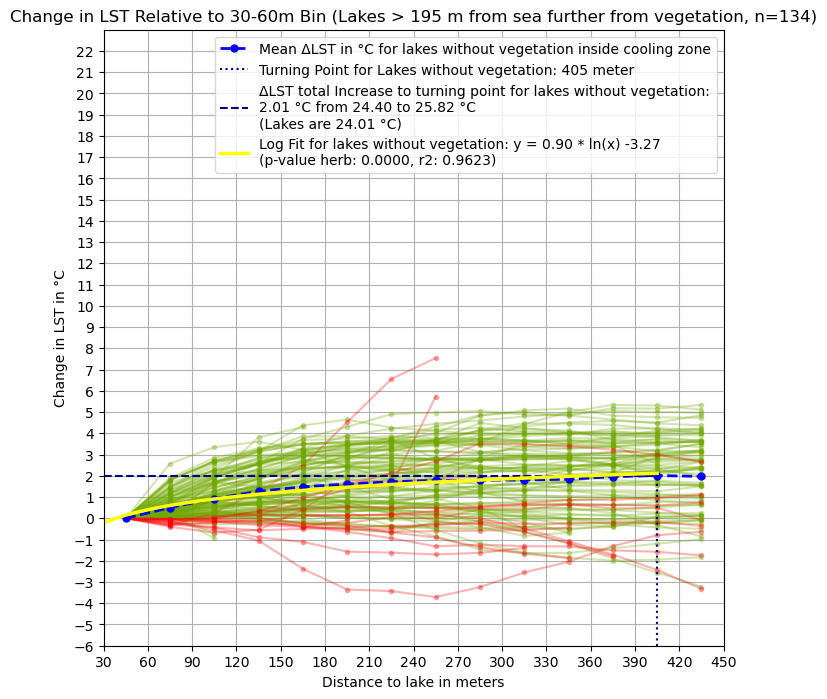

count pos without vegetation  116
count neg without vegetation  16


In [156]:
### ANALYSIS 13: LAKES WITHOUT VEGETATION
# Cooling effect from lakes close to vegetation (herbs + forest) vs. 
# lakes not close to urban atlas vegetation (herbs+forest) - long distance
#  only calculates for lakes > 195 meters from the sea 

# Define distance bins (30-60, 60-90, ..., 390-420)
bins = np.arange(30, 480, 30)
bin_labels = bins[:-1] + 15  # Midpoints of each bin

# Filter lake ids with herb
lakes_filtered_cool = lakes[lakes['cool_trend'].isin(['positive', 'negative'])] #159
lakes_herb_statistics_ids = np.sort(np.unique(lakes_filtered_cool['id']))

lakes_filtered_herb = lakes_filtered_cool[lakes_filtered_cool['vegOverlap'] >= 1] #25 
lakes_with_herb_ids = np.sort(np.unique(lakes_filtered_herb['id']))

lakes_without_herb_ids = np.setdiff1d(lakes_herb_statistics_ids, lakes_with_herb_ids)
lakes_without_herb = lakes_filtered_cool[lakes_filtered_cool['id'].isin(lakes_without_herb_ids)] #134

plt.figure(figsize=(8, 8))  # Initialize figure

# Storage for mean ΔLST across all lakes
all_delta_lst_herb = []
all_delta_lst_not_herb = []

# Storage for zero LST across all lakes
all_lst_at_0_herb = []
all_lst_at_0_not_herb = []

# Storage for 30-60 LST across all lakes
all_lst_at_30_60_herb = []
all_lst_at_30_60_not_herb = []

count_pos = 0
count_neg = 0

# Iterate through each unique lake ID
for lake_id in lakes_without_herb_ids:
    base_mask = (lakes_source_near == lake_id) & (lake_dist < 800) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 0` (not used as reference)
    lst_at_0_mask = base_mask & (lake_dist == 0)
    lst_at_0 = np.mean(lst[lst_at_0_mask]) if np.any(lst_at_0_mask) else np.nan

    if lake_id in lakes_without_herb_ids:
        all_lst_at_0_not_herb.append(lst_at_0)
    
    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    if lake_id in lakes_without_herb_ids:
        all_lst_at_30_60_not_herb.append(lst_at_30_60)

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    if lake_id in lakes_without_herb_ids:
        all_delta_lst_not_herb.append(delta_lst)
   
    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if lake_id in lakes_without_herb_ids: 
                #line_color = '#187DE9' # lakes without herb is colored blue='#187DE9'
                line_color = '#70A800' if delta_lst[index_75] > delta_lst[index_45] else '#FF0000' 
                if line_color == '#70A800':
                    count_pos += 1 
                elif line_color == '#FF0000':
                    count_neg += 1
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    # Plot individual lake ΔLST curves in the background
    plt.plot(bin_labels, delta_lst, color=line_color, marker='o', linestyle='-', markersize=3, alpha=0.3)  # Transparency for background plots

# Compute mean ΔLST across all lakes starting from bin 30-60
#mean_delta_lst_herb = np.nanmean(np.array(all_delta_lst_herb), axis=0)
mean_delta_lst_not_herb = np.nanmean(np.array(all_delta_lst_not_herb), axis=0)

# Compute LST across all lakes for dist=0
mean_lst_at_0_not_herb = np.nanmean(np.array(all_lst_at_0_not_herb), axis=0)

# Compute LST across all lakes for dist=30-60
mean_lst_at_30_60_not_herb = np.nanmean(np.array(all_lst_at_30_60_not_herb), axis=0)

# Compute the slope between successive bins
slopes_not_herb = np.diff(mean_delta_lst_not_herb) / np.diff(bin_labels)

# Find turning point (last increasing point before a decrease)
turning_point_index_not_herb = np.argmax(slopes_not_herb < 0)

#    turning_point_distance_herb = np.nan
if turning_point_index_not_herb > 0:
    turning_point_distance_not_herb = bin_labels[turning_point_index_not_herb]
else:
    turning_point_distance_not_herb = np.nan

info_data_type= "lakes_withoutVegetation"

# Add TP information to list: 
try: 
    dict_for_counting_TP[info_data_type] = {
        "turning_point": turning_point_lst_not_herb,
        "distance": turning_point_distance_not_herb
    }
except: 
    print("dict_for_counting_TP does not yet exist")

# Add positive count to list: 
try: 
    dict_for_counting_n_pos[info_data_type] = {
        "n_pos": count_pos
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")
    
# Add positive count to list: 
try: 
    dict_for_counting_n_neg[info_data_type] = {
        "n_neg": count_neg
    }
except: 
    print("dict_for_counting_n_pos does not yet exist")

# Get LST at the turning point which equals LST increase 
#turning_point_lst_herb = mean_delta_lst_herb[turning_point_index_herb] if not np.isnan(turning_point_distance_herb) else np.nan
turning_point_lst_not_herb = mean_delta_lst_not_herb[turning_point_index_not_herb] if not np.isnan(turning_point_distance_not_herb) else np.nan

# Print results
print(f"LST at Lakes not Herb (0m): {mean_lst_at_0_not_herb}")
print(f"Turning Point Distance not Herb (last increasing point before decrease): {turning_point_distance_not_herb} meters")
print(f"LST at First Bin not Herb (30-60m): {mean_lst_at_30_60_not_herb}")
print(f"LST at Turning Point not Herb: {mean_lst_at_30_60_not_herb+turning_point_lst_not_herb}")
print(f"LST Increase Between First Bin (30-60m) and Turning Point not Herb: {turning_point_lst_not_herb}")

# start the plotting 
plt.xlim(bins[1], bins[-1])
y_start = -6
y_end = 23
plt.ylim(y_start, y_end)

# Plots for lakes without herb:
# Plot the mean ΔLST across all lakes
plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, #darkgreen
         label="Mean ΔLST in °C for lakes without vegetation inside cooling zone")
# Vertical line at turning point
plt.vlines(turning_point_distance_not_herb, ymin=y_start, ymax=turning_point_lst_not_herb, color='darkblue', linestyle='dotted', 
            label=f"Turning Point for Lakes without vegetation: {turning_point_distance_not_herb} meter")
# Add horizontal line at turning point LST
plt.hlines(turning_point_lst_not_herb, 30, turning_point_distance_not_herb, color='darkblue', linestyle='--', 
           label=f"ΔLST total Increase to turning point for lakes without vegetation:\n{turning_point_lst_not_herb:.2f} °C from {(mean_lst_at_30_60_not_herb):.2f} to {(mean_lst_at_30_60_herb+turning_point_lst_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")
# Logarithmic Fit (only for data before the turning point)
if not np.isnan(turning_point_distance_not_herb):
    valid_indices_not_herb = (np.array(bin_labels) >= 30) & (np.array(bin_labels) <= turning_point_distance_not_herb)
    x_fit_not_herb = np.array(bin_labels)[valid_indices_not_herb]
    y_fit_not_herb = np.array(mean_delta_lst_not_herb)[valid_indices_not_herb]

    # Remove NaN values
    valid_mask_not_herb = ~np.isnan(y_fit_not_herb)
    x_fit_not_herb = x_fit_not_herb[valid_mask_not_herb]
    y_fit_not_herb = y_fit_not_herb[valid_mask_not_herb]

    if len(x_fit_not_herb) > 1:
        x_log_not_herb = np.log(x_fit_not_herb)
        x_log_with_const_not_herb = sm.add_constant(x_log_not_herb)
        model_not_herb = sm.OLS(y_fit_not_herb, x_log_with_const_not_herb)
        results_not_herb = model_not_herb.fit()

        a_not_herb = results_not_herb.params[1]
        b_not_herb = results_not_herb.params[0]
        p_value_not_herb = results_not_herb.pvalues[1]
        r2_value_not_herb = results_not_herb.rsquared

        # Logarithmic fit curve
        x_fit_line_not_herb = np.linspace(30, turning_point_distance_not_herb, 100)
        y_fit_line_not_herb = a_not_herb * np.log(x_fit_line_not_herb) + b_not_herb
        plt.plot(x_fit_line_not_herb, y_fit_line_not_herb, color='yellow', linestyle='-', linewidth=2.5, #'lightblue' 
                 label=f"Log Fit for lakes without vegetation: y = {a_not_herb:.2f} * ln(x) {b_not_herb:.2f}\n(p-value herb: {p_value_not_herb:.4f}, r2: {r2_value_not_herb:.4f})")

        print(f"P-value for logarithmic lakes without vegetation fit: {p_value_not_herb:.4f}")
        if p_value_not_herb < 0.05:
            print("The logarithmic fit is statistically significant.")

# Plot the mean ΔLST across all lakes
#plt.plot(bin_labels, mean_delta_lst_not_herb, color='blue', marker='o', linestyle='--', linewidth=2, markersize=5, 
#         label=f"Mean ΔLST in °C for lakes without vegetation inside cooling zone\nNo turning point for lakes without vegetation:\nstarting from: {(mean_lst_at_30_60_not_herb):.2f} °C\n(Lakes are {mean_lst_at_0_not_herb:.2f} °C)")

# Final plot adjustments
plt.xlabel("Distance to lake in meters")
plt.ylabel("Change in LST in °C")
plt.title(f"Change in LST Relative to 30-60m Bin (Lakes > 195 m from sea further from vegetation, n={134})") #len(lakes_without_herb_ids)=151 but 3 are outOfScope
plt.xticks(bins)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
# Move legend to the top left corner
plt.legend(loc='upper right')
plt.savefig("Fig20190606_lakesWithoutVegetation.png", dpi=400, bbox_inches="tight")
plt.show()
print("count pos without vegetation ", count_pos)
print("count neg without vegetation ", count_neg)



In [157]:
print(dict_for_counting_TP)
print(dict_for_counting_n_pos)
print(dict_for_counting_n_neg)

{'sea': {'turning_point': np.float64(2.6277111645368576), 'distance': np.int64(225)}, 'sea_coastal': {'turning_point': np.float64(4.061073016251015), 'distance': np.int64(195)}, 'sea_inner_harbour': {'turning_point': np.float64(2.564297619522266), 'distance': np.int64(225)}, 'lakes': {'turning_point': np.float64(1.5410510652652085), 'distance': np.int64(255)}, 'lakes_larger': {'turning_point': np.float64(2.832788168458443), 'distance': np.int64(285)}, 'lakes_small': {'turning_point': np.float64(1.2773217832929469), 'distance': np.int64(255)}, 'lakes_areaDivPeri': {'turning_point': np.float64(2.6242733586574585), 'distance': np.int64(315)}, 'lakes_withVegetation': {'turning_point': np.float64(0.6279699655335741), 'distance': np.int64(135)}, 'lakes_withoutVegetation': {'turning_point': np.float64(2.0111343223061673), 'distance': np.int64(405)}}
{'sea': {'n_pos': 83}, 'sea_coastal': {'n_pos': 2}, 'sea_inner_harbour': {'n_pos': 81}, 'lakes': {'n_pos': 157}, 'lakes_larger': {'n_pos': 28}, '

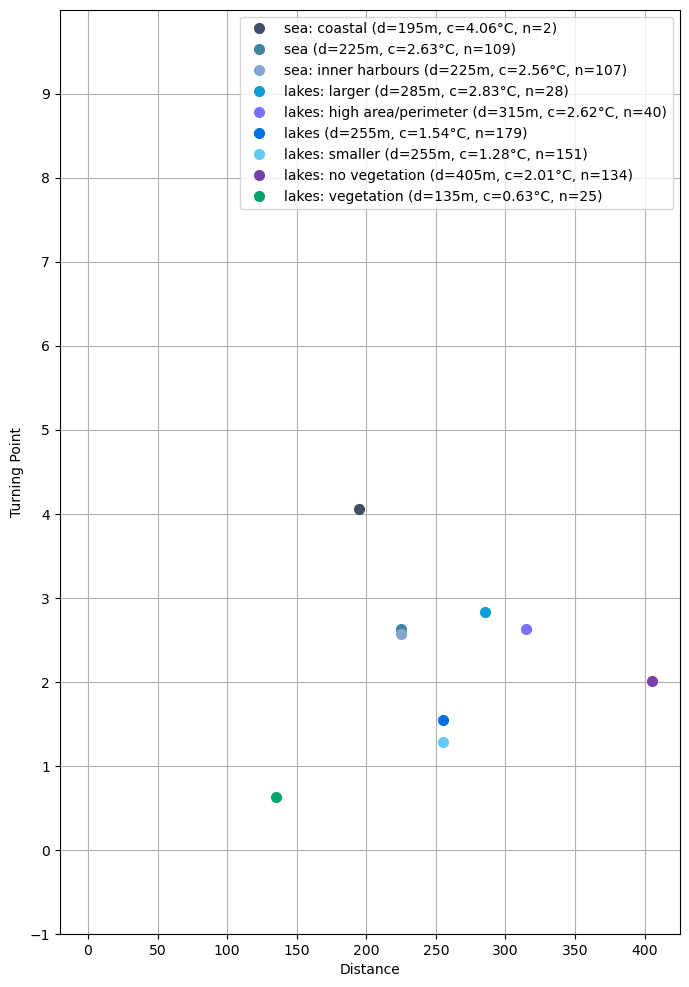

In [159]:
# Plot turning points
plt.figure(figsize=(8, 12))

colors = {
    "sea": "#4085A0",
    "sea_coastal": "#3D4E66",
    "sea_inner_harbour": "#86A5D0",
    "lakes": "#0070E2",
    "lakes_larger": "#0E9ED5",
    "lakes_small": "#62CBF5",
    "lakes_areaDivPeri": "#7771fB",
    "lakes_withVegetation": "#01A66F",
    "lakes_withoutVegetation": "#773FA8"
}

descriptions = {
    "sea": "sea",
    "sea_coastal": "sea: coastal",
    "sea_inner_harbour": "sea: inner harbours",
    "lakes": "lakes",
    "lakes_larger": "lakes: larger",
    "lakes_small": "lakes: smaller",
    "lakes_areaDivPeri": "lakes: high area/perimeter",
    "lakes_withVegetation": "lakes: vegetation",
    "lakes_withoutVegetation": "lakes: no vegetation"
}

n_s = {
    "sea": "109",
    "sea_coastal": "2",
    "sea_inner_harbour": "107",
    "lakes": "179",
    "lakes_larger": "28",
    "lakes_small": "151",
    "lakes_areaDivPeri": "40",
    "lakes_withVegetation": "25",
    "lakes_withoutVegetation": "134"
}

legend_entries = []  # (slope, handle, label)

for label, values in dict_for_counting_TP.items():
    x = values["distance"]
    y = values["turning_point"]
    slope = y / x

    color = colors[label]
    description = descriptions[label]
    n = n_s[label]

    # plot point
    point, = plt.plot(x, y, marker="o", markersize=7, linestyle="None", label=description, color=color)

    # plot line from origin using same color
    plt.plot([0, x], [0, y], color="none", linestyle="-") #color

    # create legend label including distance and turning point
    legend_label = f"{description} (d={x}m, c={y:.2f}°C, n={n})"

    # store for legend sorting
    legend_entries.append((slope, point, legend_label))

# ---- sort legend by slope (highest first) ----
legend_entries.sort(key=lambda t: t[0], reverse=True)

handles = [t[1] for t in legend_entries]
labels = [t[2] for t in legend_entries]

plt.xlabel("Distance")
plt.ylabel("Turning Point")
plt.legend(handles=handles, labels=labels) #, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=1
y_start = -1
y_end = 10
plt.ylim(y_start, y_end)
yticks = np.arange(y_start, y_end, 1)  # Adjust range and step as needed
plt.yticks(yticks)
plt.grid(True)
plt.savefig("Fig20190606_turningpoints.png", dpi=400, bbox_inches="tight")
plt.show()